In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce

In [2]:
path = os.getcwd()+'/user_epoch/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

clean = []
csex = []
cage = []
cdf = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
        if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                 
            cdf.append(df)
            demo_info = f.split("/")[-1].split('.')[0]
            csex.append(re.split('(\d+)',demo_info)[0])
            cage.append(int(re.split('(\d+)',demo_info)[1]))
            clean.append(int(f.split("/")[-1].split('.')[1][1:])) 
      

In [3]:
path = os.getcwd()+'/match_c/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

mclean = []
mcsex = []
mcage = []
mcdf = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    if len(df['phase'].unique()) >= 4: #and 0 in df['phase'].unique() and 1 in df['phase'].unique():
        if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                
                mcdf.append(df)
                demo_info = f.split("/")[-1].split('.')[0]
                
                mclean.append(int(f.split("/")[-1].split('.')[1][1:]))  
                mcsex.append(re.split('(\d+)',demo_info)[0])
                mcage.append(int(re.split('(\d+)',demo_info)[1]))
  

In [4]:
def sliding_window(elements, window_size):
    wi_days = []
    for i in range(1,len(elements)+1):
        if i >= window_size:
            wi_days.append(elements[i-window_size:i])
        elif i < window_size:
            wi_days.append(elements[:i])
    return wi_days

In [5]:
perss_user = pd.DataFrame(data =  np.array([clean, csex, cage]).T,columns = ['uid', 'sex', 'age'])
match_user = pd.DataFrame(data =  np.array([mclean, mcsex, mcage]).T,columns = ['uid', 'sex', 'age'])
#mu_idx = [np.where(np.array(muid) == i)[0][0] for i in [int(i) for i in match_user[(match_user.sex == 'male')&(match_user.age == '60')]['uid'].iloc[:5].values]]
#pu_idx = np.where(np.array(uid) == int(perss_user[(perss_user.sex=='male')&(perss_user.age=='60')]['uid'].iloc[0]))[0][0]  

In [6]:
used = []
mids = []

for n in range(len(perss_user)):
    r = perss_user.iloc[n]

    mid = np.random.choice(match_user[(match_user.sex == r.sex)&(match_user.age == r.age)&(~match_user.uid.isin(used))].index, 5,replace=False)
    mids.append(mid)
    for i in match_user[match_user.index.isin(mid)].uid.values:
        used.append(i)

In [7]:
mids = np.concatenate(mids)

In [8]:
dtpts = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(mids)))
i = 0
for m in mids:
    tmp = mcdf[m]
    tmp = tmp[(pd.to_timedelta(tmp.day_totest).dt.days >= -62)&(pd.to_timedelta(tmp.day_totest).dt.days < 180)]
    dtpts.loc[pd.to_timedelta(tmp.groupby('day_totest').count().index),i] = tmp.groupby('day_totest').count().hr.values
    i+=1

In [9]:
# bins = np.linspace(np.nanmin(dtpts), np.nanmax(dtpts), 30)
# h = np.zeros((len(bins)-1,len(dtpts)))
# for d in range(len(dtpts)):
#     h[:,d] = np.histogram(dtpts.iloc[d], bins=bins)[0]


In [10]:
umax = []
umin = []
for d in range(len(dtpts)-1):
    umax.append(np.where(dtpts.iloc[d] == np.nanmax(dtpts.iloc[d]))[0])
    umin.append(np.where(dtpts.iloc[d] == np.nanmin(dtpts.iloc[d]))[0])

In [11]:
from collections import Counter

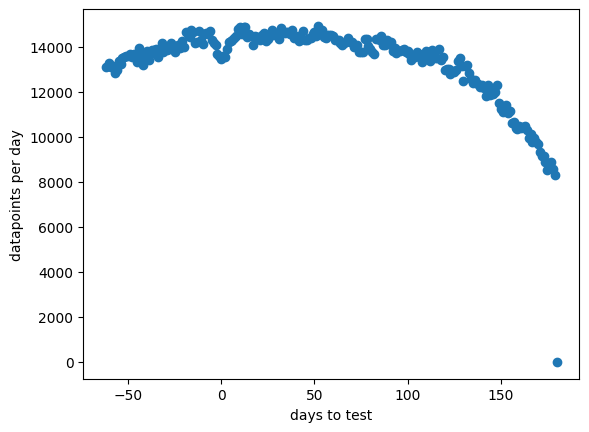

In [12]:
plt.scatter(dtpts.index.days,dtpts.sum(axis=1))
plt.xlabel('days to test')
plt.ylabel('datapoints per day');

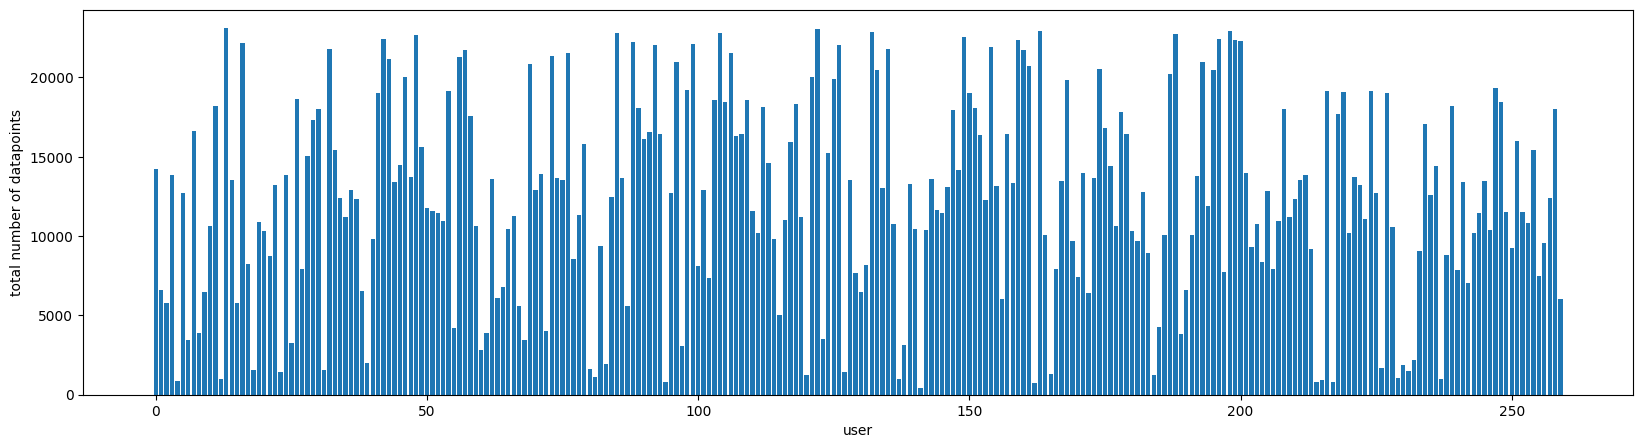

In [13]:
plt.figure(figsize=(20,5))
plt.bar(dtpts.sum(axis=0).index,dtpts.sum(axis=0).values)
plt.xlabel('user')
plt.ylabel('total number of datapoints');

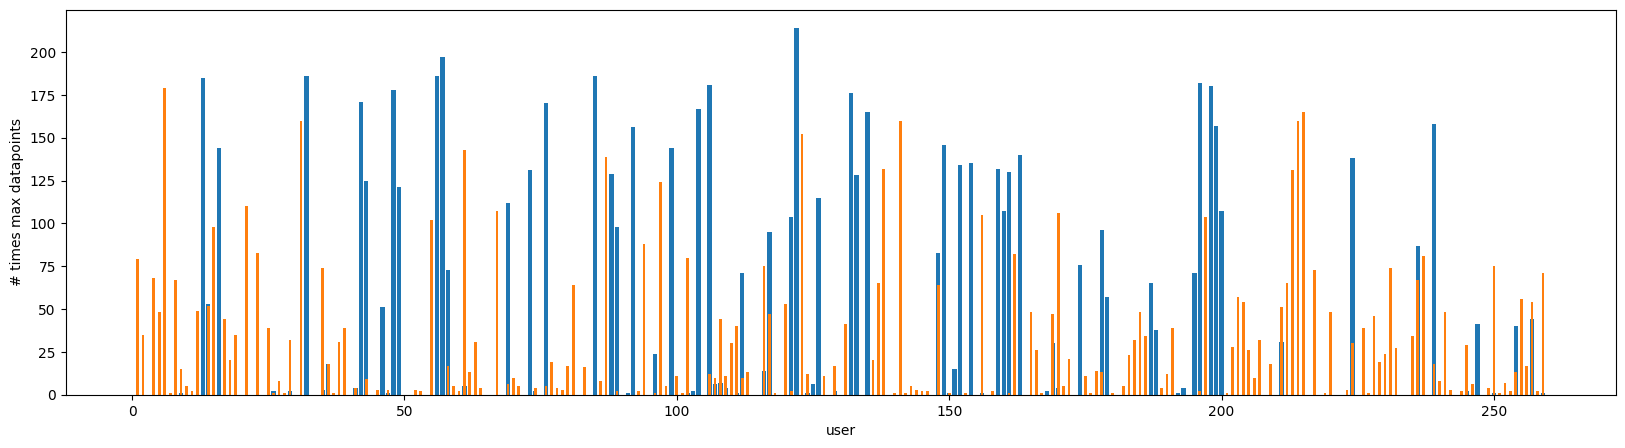

In [14]:
plt.figure(figsize=(20,5))
plt.bar(Counter(np.concatenate(umax)).keys(),Counter(np.concatenate(umax)).values())
plt.bar(Counter(np.concatenate(umin)).keys(),Counter(np.concatenate(umin)).values(),width=.5)
plt.xlabel('user')
plt.ylabel('# times max datapoints');

In [15]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

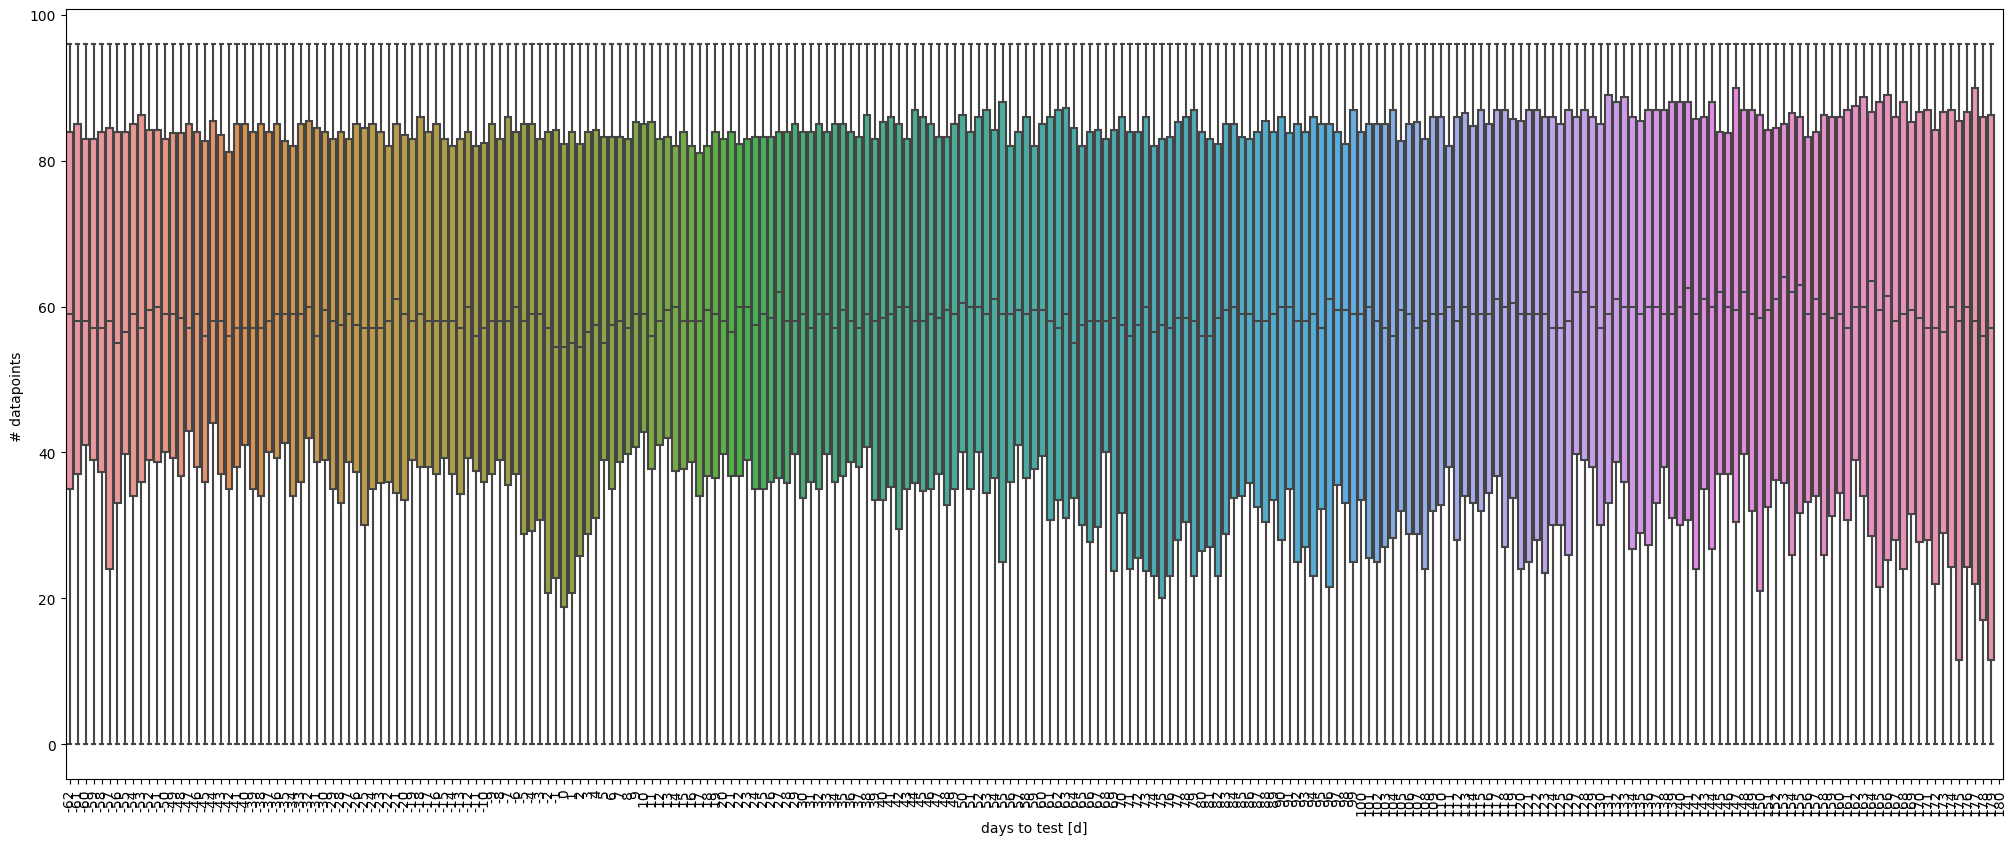

In [16]:
plt.figure(figsize=(25,10))
ax = sns.boxplot(dtpts.T)
ax.set_xticklabels(dtpts.index.days,rotation = 90);
ax.set_xlabel('days to test [d]')
ax.set_ylabel('# datapoints ');

In [17]:
def sign(hnight, hday, hnightm, hdaym , dtt_range, df_lc, df_mu_list):
    
    subd = df_lc[df_lc['day_totest'].apply(lambda x: x in dtt_range)].copy()
    subd['start'] = pd.to_datetime(subd['start'])
    subd = subd[subd['start'].notna()]
    night = []
    day = []
    if len(subd) > 0:
        night = subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['hr'].dropna() - hnight
        day = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']!=0))]['hr'].dropna() - hday
    
    nightm = []
    daym = []
    for m in range(len(df_mu_list)):
        match = df_mu_list[m]
        subd = match[match['day_totest'].apply(lambda x: x in dtt_range)].copy()
        subd['start'] = pd.to_datetime(subd['start'])
        subd = subd[subd['start'].notna()]
        if len(subd) > 0:
            nightm.append(subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['hr'].dropna() - hnightm[m])
            daym.append(subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']!=0))]['hr'].dropna() - hdaym[m])
    nightm = np.concatenate(nightm, axis=0)
    daym = np.concatenate(daym, axis=0)
    
    if len(night) > 0: 
        n_bool = stats.ttest_ind(nightm, night, equal_var=False)[1] < 0.05 
        
        n_boolu = stats.ttest_ind(night, nightm, equal_var=False, alternative='greater')[1] < 0.05
        n_booll = stats.ttest_ind(night, nightm, equal_var=False, alternative='less')[1] < 0.05
    else:
        n_bool = np.nan
        n_boolu =np.nan
        n_booll =np.nan
    if len(day) >0 :
        d_bool = stats.ttest_ind(daym, day, equal_var=False)[1] < 0.05
        d_boolu = stats.ttest_ind(day, daym, equal_var=False, alternative='greater')[1] < 0.05
        d_booll = stats.ttest_ind(day, daym, equal_var=False, alternative='less')[1] < 0.05
    else:
        d_bool = np.nan
        d_boolu = np.nan
        d_booll = np.nan
    
    return night, day, nightm, daym, n_bool, n_boolu, n_booll, d_bool, d_boolu, d_booll

In [18]:
dtt_list = sliding_window(pd.timedelta_range(pd.Timedelta(-62,'d'),pd.Timedelta(120,'d')),7)

In [19]:
import seaborn as sns

In [20]:
# plt.figure(figsize=(25,5))
# ax=sns.boxplot(sign_df[2])
# ax.set_xticklabels(sign_df.index.days,rotation = 90);
# plt.scatter(range(len(sign_df.index.days)),[-25]*len(sign_df.index), c=['red' if i == True else 'white' for i in  sign_df[4]])
# ax.set_title('rhr match');

In [21]:
from scipy import stats

In [22]:
used = []
night_s_idxs = []
day_s_idxs = []
nsu_i = []
nsl_i = []
dsu_i = []
dsl_i = []
for n in range(len(perss_user)):
    r = perss_user.iloc[n]

    mid = np.random.choice(match_user[(match_user.sex == r.sex)&(match_user.age == r.age)&(~match_user.uid.isin(used))].index, 5,replace=False)
    for i in match_user[match_user.index.isin(mid)].uid.values:
        used.append(i)


    lcdf = cdf[n]
    lcdf['dt'] = pd.to_datetime(lcdf['dt'])
    lcdf['date'] = pd.to_datetime(lcdf['date'])
    lcdf['day_totest'] = lcdf['date'] - lcdf['dt']
    lcdf = lcdf.sort_values(by='date')
    mis_row = []
    for dt in [d for d in pd.date_range(start = lcdf['date'].min(), end = lcdf['date'].max()).difference(lcdf.index) if d not in lcdf['date'].unique()]:
        mis_row.append([
                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - lcdf['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        lcdf = lcdf.append(pd.DataFrame(data=mis_row, columns=lcdf.columns))

    mdf = []
    for ui in mid : #np.where(ms_i & ma_i)[0] 
        df = mcdf[ui]
        df['dt'] = pd.to_datetime(df['dt'])
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(by='date')
        mis_row = []
        for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
            mis_row.append([
                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
        if len(mis_row) > 0:
            df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
        mdf.append(df)

    healthy_wind = lcdf[(lcdf.day_totest < datetime.timedelta(days = -7))&(lcdf.day_totest >= datetime.timedelta(days = -62))].copy()
    healthy_wind.loc[:,'start'] = pd.to_datetime(healthy_wind['start'])
    healthy_wind = healthy_wind[healthy_wind['start'].notna()]
    hnight = healthy_wind[(healthy_wind['start'].dt.time < pd.to_datetime('07:00:00').time())&((healthy_wind['steps'].isna())|(healthy_wind['steps']==0))]['hr'].dropna().mean()
    hday = healthy_wind[(healthy_wind['start'].dt.time >= pd.to_datetime('07:00:00').time())&((healthy_wind['steps'].notna())&(healthy_wind['steps']!=0))]['hr'].dropna().mean()

    hnightm = []
    hdaym = []
    for m in mdf:
        m.loc[:,'day_totest'] = pd.to_timedelta(m.day_totest)
        healthy_wind = m[(m.day_totest < datetime.timedelta(days = -7))&(m.day_totest >= datetime.timedelta(days = -62))].copy()
        healthy_wind.loc[:,'start'] = pd.to_datetime(healthy_wind['start'])
        healthy_wind = healthy_wind[healthy_wind['start'].notna()]
        hnightm.append(healthy_wind[(healthy_wind['start'].dt.time < pd.to_datetime('07:00:00').time())&((healthy_wind['steps'].isna())|(healthy_wind['steps']==0))]['hr'].dropna().mean())
        hdaym.append(healthy_wind[(healthy_wind['start'].dt.time >= pd.to_datetime('07:00:00').time())&((healthy_wind['steps'].notna())&(healthy_wind['steps']!=0))]['hr'].dropna().mean())

    sign_df = pd.DataFrame(index = pd.timedelta_range(pd.Timedelta(-62,'d'),pd.Timedelta(120,'d')), columns = range(10) )
    for d in range(len(dtt_list)):

        lcn, lcd, mn, md, sign_n, signn_u, signn_l, sign_d, signd_l, signd_u = sign(hnight, hday, hnightm, hdaym, dtt_list[d], lcdf, mdf)
        sign_df.iloc[d,0] = lcn
        sign_df.iloc[d,1] = lcd
        sign_df.iloc[d,2] = mn
        sign_df.iloc[d,3] = md
        sign_df.iloc[d,4] = sign_n
        sign_df.iloc[d,5] = signn_u
        sign_df.iloc[d,6] = signn_l
        sign_df.iloc[d,7] = sign_d
        sign_df.iloc[d,8] = signd_u
        sign_df.iloc[d,9] = signd_l

    night_s_idxs.append(np.where(sign_df[4])[0])
    day_s_idxs.append(np.where(sign_df[7])[0])
    nsu_i.append(np.where(sign_df[5])[0])
    nsl_i.append(np.where(sign_df[6])[0])
    dsu_i.append(np.where(sign_df[8])[0])
    dsl_i.append(np.where(sign_df[9])[0])

In [23]:
np.save('dsidx.npy',np.array(day_s_idxs, dtype=object),allow_pickle=True)
np.save('nsidx.npy',np.array(night_s_idxs, dtype=object),allow_pickle=True)

In [24]:
np.save('dslidx.npy',np.array(dsl_i, dtype=object),allow_pickle=True)
np.save('nslidx.npy',np.array(nsl_i, dtype=object),allow_pickle=True)
np.save('dsuidx.npy',np.array(dsu_i, dtype=object),allow_pickle=True)
np.save('nsuidx.npy',np.array(nsu_i, dtype=object),allow_pickle=True)

In [25]:
scd = []
scn = []
scdl = []
scdu = []
scnl = []
scnu = []
for d in range(len(sign_df.index)):
    
    scd.append(sum([True if d in i else False for i in day_s_idxs ]))
    scn.append(sum([True if d in i else False for i in night_s_idxs ]))
    
    scdl.append(sum([True if d in i else False for i in dsl_i ]))
    scdu.append(sum([True if d in i else False for i in dsu_i ]))
    
    scnl.append(sum([True if d in i else False for i in nsl_i ]))
    scnu.append(sum([True if d in i else False for i in nsu_i ]))
    

In [26]:
bins = np.linspace(0, 170,20)

In [27]:
# does sgin aling w upper lower, normalize per sign day and user

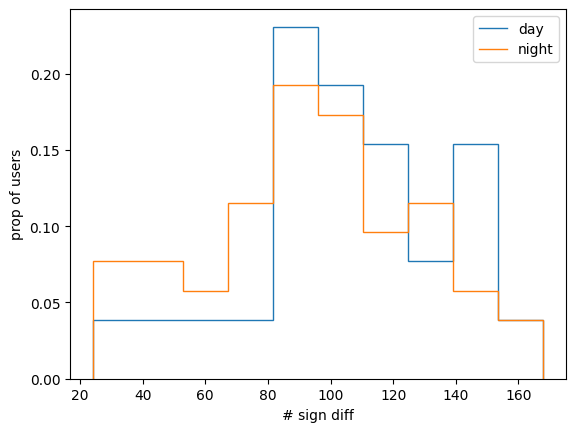

In [28]:
n_d, bins = np.histogram([len(i) for i in day_s_idxs])
n_n, bins = np.histogram([len(i) for i in night_s_idxs])

plt.stairs(n_d/len(day_s_idxs), bins, fill=False)
plt.stairs(n_n/len(night_s_idxs), bins, fill=False)
plt.xlabel('# sign diff')
plt.ylabel('prop of users');
plt.legend(['day','night']);

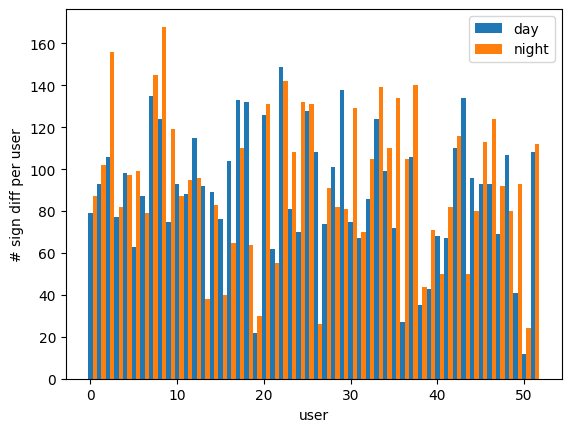

In [29]:
plt.bar(np.array(range(len(day_s_idxs))), [len(i) for i in day_s_idxs],width=0.5)
plt.bar(np.array(range(len(day_s_idxs)))+.5, [len(i) for i in night_s_idxs],width=0.5)
plt.ylabel('# sign diff per user')
plt.xlabel('user')
plt.legend(['day','night']);

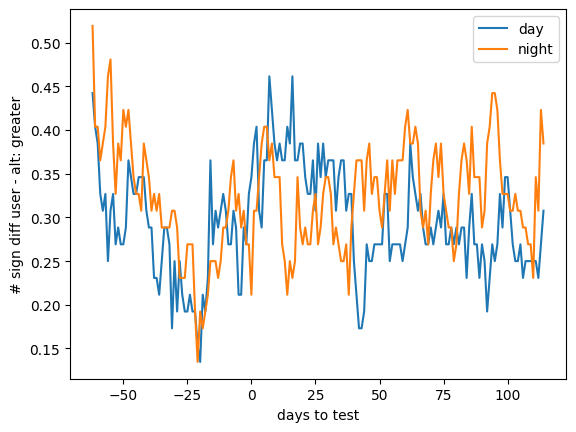

In [30]:
plt.plot(sign_df.index.days[:-6], np.array(scdu[:-6])/len(day_s_idxs))
plt.plot(sign_df.index.days[:-6], np.array(scnu[:-6])/len(night_s_idxs))
plt.legend(['day','night'])
plt.ylabel('# sign diff user - alt: greater')
plt.xlabel('days to test');

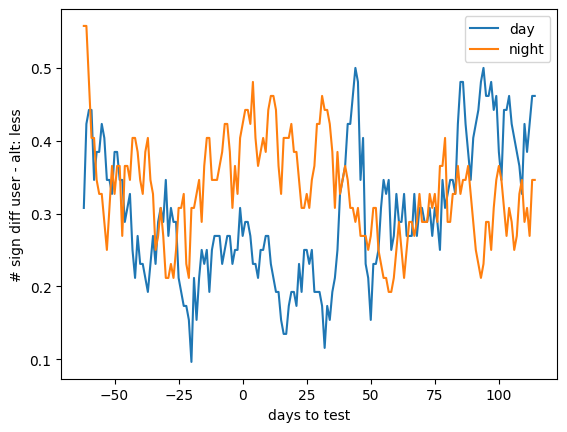

In [31]:
plt.plot(sign_df.index.days[:-6], np.array(scdl[:-6])/len(day_s_idxs))
plt.plot(sign_df.index.days[:-6], np.array(scnl[:-6])/len(night_s_idxs))
plt.legend(['day','night'])
plt.ylabel('# sign diff user - alt: less')
plt.xlabel('days to test');

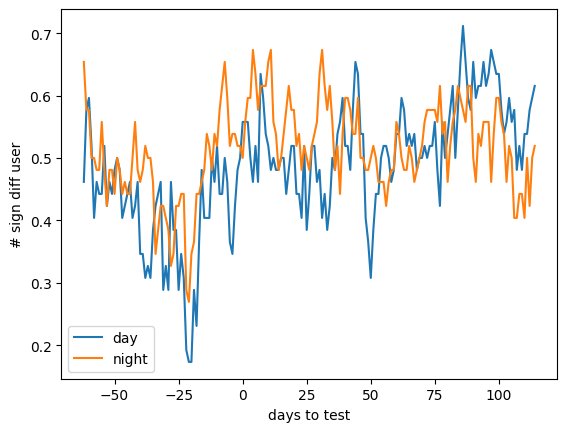

In [32]:
plt.plot(sign_df.index.days[:-6], np.array(scd[:-6])/len(day_s_idxs))
plt.plot(sign_df.index.days[:-6], np.array(scn[:-6])/len(night_s_idxs))
plt.legend(['day','night'])
plt.ylabel('# sign diff user')
plt.xlabel('days to test');

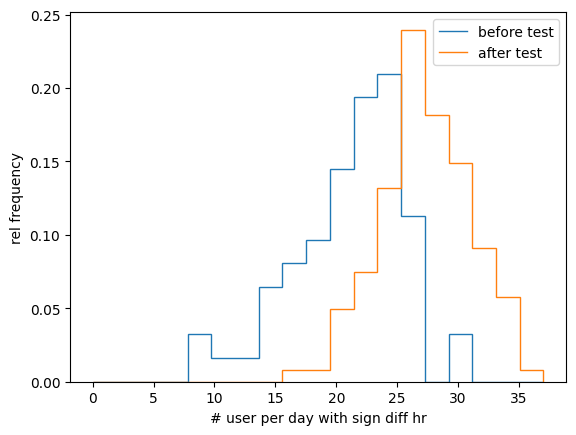

In [33]:
bins = np.linspace(0, max(scd),20)
nbt, _ = np.histogram(np.array(scd)[sign_df.index.days < 0],bins=bins)
nat, _ = np.histogram(np.array(scd)[sign_df.index.days >= 0],bins=bins)

plt.stairs(nbt/np.count_nonzero(sign_df.index.days < 0), bins, fill=False)
plt.stairs(nat/np.count_nonzero(sign_df.index.days >= 0), bins, fill=False)
plt.xlabel('# user per day with sign diff hr')
plt.legend(['before test', 'after test'])
plt.ylabel('rel frequency');

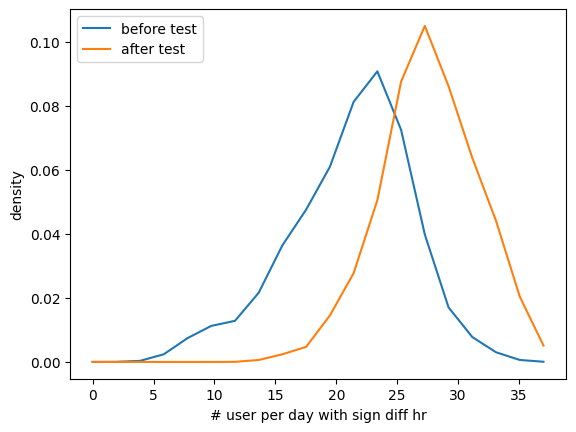

In [34]:
kernel = stats.gaussian_kde(np.array(scd)[sign_df.index.days < 0], bw_method='scott')
plt.plot(bins,kernel.evaluate(bins))
kernel = stats.gaussian_kde(np.array(scd)[sign_df.index.days >= 0], bw_method='scott')
plt.plot(bins,kernel.evaluate(bins))
plt.xlabel('# user per day with sign diff hr')
plt.legend(['before test', 'after test'])
plt.ylabel('density');

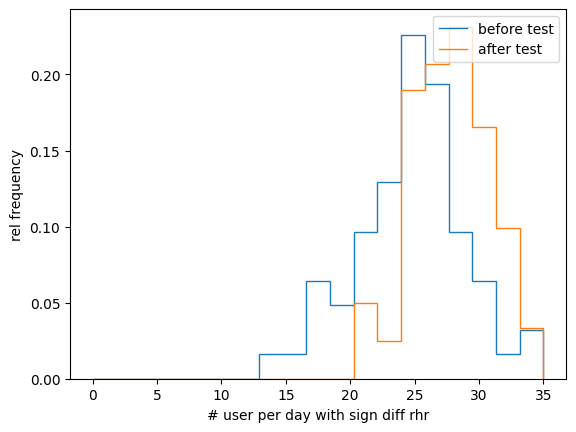

In [35]:
bins = np.linspace(0, max(scn),20)
nbt, _ = np.histogram(np.array(scn)[sign_df.index.days < 0],bins=bins)
nat, _ = np.histogram(np.array(scn)[sign_df.index.days >= 0],bins=bins)

plt.stairs(nbt/np.count_nonzero(sign_df.index.days < 0), bins, fill=False)
plt.stairs(nat/np.count_nonzero(sign_df.index.days >= 0), bins, fill=False)
plt.xlabel('# user per day with sign diff rhr')
plt.legend(['before test', 'after test'])
plt.ylabel('rel frequency');

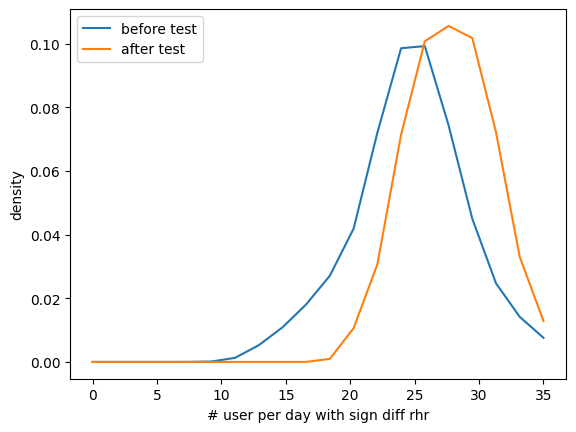

In [36]:
kernel = stats.gaussian_kde(np.array(scn)[sign_df.index.days < 0], bw_method='scott')
plt.plot(bins,kernel.evaluate(bins))
kernel = stats.gaussian_kde(np.array(scn)[sign_df.index.days >= 0], bw_method='scott')
plt.plot(bins,kernel.evaluate(bins))
plt.xlabel('# user per day with sign diff rhr')
plt.legend(['before test', 'after test'])
plt.ylabel('density');

In [ ]:
np.count_nonzero((np.concatenate(day_s_idxs) >= 0)&(np.concatenate(day_s_idxs) < 18.2))

In [ ]:
sum([True if 0 in i else False for i in day_s_idxs ])

In [ ]:
sum(sign_df[4] == True)

In [ ]:
1+5

In [ ]:
import seaborn as sns

In [ ]:
np.mean(sign_df.iloc[0][0])

In [ ]:
np.mean(sign_df.iloc[0][2])

In [ ]:
sign_df.iloc[0]

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(sign_df[0]);

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(sign_df[2]);

In [ ]:
def get_md(subd):
    subd = subd.copy()
    subd['start'] = pd.to_datetime(subd['start'])
    subd = subd[subd['start'].notna()]
    if len(subd) > 0:
        night = subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['hr'].dropna()
        day = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']!=0))]['hr'].dropna()
        rhr_rel = subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['% of MHR'].dropna()
        hr_rel = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']!=0))]['% of MHR'].dropna()
        if len(day) >= 20 and len(night) < 5:
                return 0,0,day.mean(), day.std(),0, hr_rel.mean()
        elif len(day) >= 20 and len(night) >= 5:
                return night.mean(), night.std(), day.mean(), day.std(), rhr_rel.mean(), hr_rel.mean()
        else:
            return 0,0,0,0,0,0
    else:
        return 0,0,0,0,0,0

In [ ]:
mins = []
maxs = []
minw = []
maxw = []
  
df = cdf[n]
df['dt'] = pd.to_datetime(df['dt'])
df['date'] = pd.to_datetime(df['date'])
df['day_totest'] = df['date'] - df['dt']
mins.append(df['day_totest'].min())
maxs.append(df['day_totest'].max())
minw.append(df['week_totest'].min())
maxw.append(df['week_totest'].max())
    
for ui in mid:
    df = mcdf[ui]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    mins.append(df['day_totest'].min())
    maxs.append(df['day_totest'].max())
    minw.append(df['week_totest'].min())
    maxw.append(df['week_totest'].max())

In [ ]:
lcu_day_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(1) )
lcu_night_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(1))
lcu_diff = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(1))
lcu_std_day = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(1))
lcu_std_night = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(1))
i =0
 
df = cdf[n]
df['dt'] = pd.to_datetime(df['dt'])
df['date'] = pd.to_datetime(df['date'])
df['day_totest'] = df['date'] - df['dt']
df = df.sort_values(by='date')
mis_row = []
for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
    mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
if len(mis_row) > 0:
    df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    

    #df['day_totest'] = df['date'] - df['dt']
wi_list = sliding_window(df['date'].unique(),7)
dtt_list = sliding_window(df['day_totest'].unique(),7)
for wi in range(len(wi_list)):
    nm, ns, dm, ds, rhrr, hrr = get_md(df[df['date'].isin(wi_list[wi])])
    lcu_day_mean.loc[lcu_day_mean.index.isin(dtt_list[wi]),i] =  dm
    lcu_night_mean.loc[lcu_night_mean.index.isin(dtt_list[wi]),i] =  nm
    lcu_std_day.loc[lcu_rhr_rel.index.isin(dtt_list[wi]),i] =  ds
    lcu_std_night.loc[lcu_rhr_rel.index.isin(dtt_list[wi]),i] =  ns
    if dm != 0:
        lcu_diff.loc[lcu_night_mean.index.isin(dtt_list[wi]),i] = (dm - nm)/dm
    

In [ ]:
lcu_diff = lcu_diff[(lcu_diff.index >= datetime.timedelta(days = -62)) &(lcu_diff.index <= datetime.timedelta(days = 180))]
lcu_rhr_rel = lcu_rhr_rel[(lcu_rhr_rel.index >= datetime.timedelta(days = -62)) &(lcu_rhr_rel.index <= datetime.timedelta(days = 180))]
lcu_day_mean = lcu_day_mean[(lcu_day_mean.index >= datetime.timedelta(days = -62)) &(lcu_day_mean.index <= datetime.timedelta(days = 180))]
lcu_night_mean = lcu_night_mean[(lcu_night_mean.index >= datetime.timedelta(days = -62)) &(lcu_night_mean.index <= datetime.timedelta(days = 180))]
lcu_hr_rel = lcu_hr_rel[(lcu_hr_rel.index >= datetime.timedelta(days = -62)) &(lcu_hr_rel.index <= datetime.timedelta(days = 180))]

In [ ]:
lcu_rhr_rel = lcu_rhr_rel.replace(0, np.nan)
lcu_hr_rel = lcu_hr_rel.replace(0, np.nan)
lcu_night_mean = lcu_night_mean.replace(0, np.nan)
lcu_day_mean = lcu_day_mean.replace(0, np.nan)

In [ ]:
mu_day_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mid)))
mu_night_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mid)))
mu_diff = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mid)))
mu_rhr_rel = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mid)))
mu_hr_rel = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mid)))
i = 0
for ui in mid : #np.where(ms_i & ma_i)[0] 
    df = mcdf[ui]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    
    
    #df['day_totest'] = df['date'] - df['dt']
    wi_list = sliding_window(df['date'].unique(),7)
    dtt_list = sliding_window(df['day_totest'].unique(),7)
    for wi in range(len(wi_list)):
        nm, ns, dm, ds, rhrr, hrr = get_md(df[df['date'].isin(wi_list[wi])])
        mu_day_mean.loc[mu_day_mean.index.isin(dtt_list[wi]),i] =  dm
        mu_night_mean.loc[mu_night_mean.index.isin(dtt_list[wi]),i] =  nm
        mu_rhr_rel.loc[mu_rhr_rel.index.isin(dtt_list[wi]),i] =  rhrr
        mu_hr_rel.loc[mu_rhr_rel.index.isin(dtt_list[wi]),i] = hrr
        if dm != 0:
            mu_diff.loc[mu_night_mean.index.isin(dtt_list[wi]),i] = (dm - nm)/dm
    i += 1
        

In [ ]:
mu_diff = mu_diff[(mu_diff.index >= datetime.timedelta(days = -62)) &(mu_diff.index <= datetime.timedelta(days = 180))]
mu_rhr_rel = mu_rhr_rel[(mu_rhr_rel.index >= datetime.timedelta(days = -62)) &(mu_rhr_rel.index <= datetime.timedelta(days = 180))]
mu_hr_rel = mu_hr_rel[(mu_hr_rel.index >= datetime.timedelta(days = -62)) &(mu_hr_rel.index <= datetime.timedelta(days = 180))]
mu_day_mean = mu_day_mean[(mu_day_mean.index >= datetime.timedelta(days = -62)) &(mu_day_mean.index <= datetime.timedelta(days = 180))]
mu_night_mean = mu_night_mean[(mu_night_mean.index >= datetime.timedelta(days = -62)) &(mu_night_mean.index <= datetime.timedelta(days = 180))]

In [ ]:

mu_night_mean = mu_night_mean.replace(0, np.nan)
mu_day_mean = mu_day_mean.replace(0, np.nan)

mu_rhr_rel = mu_rhr_rel.replace(0, np.nan)
mu_hr_rel = mu_hr_rel.replace(0, np.nan)

In [ ]:
#plt.figure(figsize=(15,6)) 
#lcu_diffrel = lcu_diff - lcu_diff[lcu_diff.index < pd.Timedelta(days=-7)].mean(axis=0).values[0]
#plt.plot(lcu_diffrel.index.days, lcu_diffrel.mean(axis=1))

In [ ]:
plt.figure(figsize=(15,6))
#plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1) );
lcumeanrhrrel = lcu_night_mean - lcu_night_mean[lcu_night_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(lcumeanrhrrel.index.days, lcumeanrhrrel.mean(axis=1))
#plt.errorbar(lcumeanrhrrel.index.days,lcumeanrhrrel.mean(axis=1),yerr = lcumeanrhrrel.std(axis=1)/np.sqrt(lcumeanrhrrel.notna().sum(axis=1).values), fmt=".")
mumeanrhrrel = mu_night_mean - mu_night_mean[mu_night_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(mumeanrhrrel.index.days, mumeanrhrrel.mean(axis=1))
#plt.errorbar(mumeanrhrrel.index.days,mumeanrhrrel.mean(axis=1),yerr = mumeanrhrrel.std(axis=1)/np.sqrt(mumeanrhrrel.notna().sum(axis=1).values), fmt=".")
#plt.errorbar(lcumeanrhrrel.index.days,lcumeanrhrrel.mean(axis=1),yerr = lcumeanrhrrel.std(axis=1)/np.sqrt(lcumeanrhrrel.notna().sum(axis=1).values), fmt=".")

 
plt.xlabel('days to test')
#plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
plt.ylabel('mean rhr relative to mean in healthy window');

In [ ]:
plt.figure(figsize=(15,6))
#plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1) );
lcumeanhrrel = lcu_day_mean - lcu_day_mean[lcu_day_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(lcumeanhrrel.index.days, lcumeanhrrel.mean(axis=1)) 
mumeanhrrel = mu_day_mean - mu_day_mean[mu_day_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(mumeanhrrel.index.days, mumeanhrrel.mean(axis=1))
plt.xlabel('days to test')
#plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
plt.ylabel('mean hr relative to mean in healthy window');

In [ ]:
plt.figure(figsize=(15,6))
mumeanrhrrel = mu_night_mean - mu_night_mean[mu_night_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(mumeanrhrrel.index.days, mumeanrhrrel.mean(axis=1))
plt.errorbar(mumeanrhrrel.index.days,mumeanrhrrel.mean(axis=1),yerr = mumeanrhrrel.std(axis=1)/np.sqrt(mumeanrhrrel.notna().sum(axis=1).values), fmt=".")
plt.xlabel('days to test') 
plt.ylabel('mean rhr relative to mean in healthy window');

In [ ]:
plt.figure(figsize=(15,6))
mumeanhrrel = mu_day_mean - mu_day_mean[mu_day_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(mumeanhrrel.index.days, mumeanhrrel.mean(axis=1))
plt.errorbar(mumeanhrrel.index.days,mumeanhrrel.mean(axis=1),yerr = mumeanhrrel.std(axis=1)/np.sqrt(mumeanhrrel.notna().sum(axis=1).values), fmt=".")
plt.xlabel('days to test') 
plt.ylabel('mean hr relative to mean in healthy window');